# Estimation of Navier-Stokes equation
## Done by: Andreea-Ioana Florea

In [49]:
!pip install deepxde

In [50]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [78]:
# -----------------------------
# Geometry parameters
# -----------------------------
Ly = 1.0          # channel height
Lx = 5.0          # channel length

# Throat (constriction)
x_throat_start = -1.8
throat_length  = 0.6
throat_gap     = 0.22   # passage height (small)
throat_margin  = 0.02   # keep a tiny margin from walls

# Cylinder array region
x_array_start  = x_throat_start + throat_length + 0.25
x_array_end    = Lx/2 - 0.3

r_cyl          = 0.05   # cylinder radius
pitch_x        = 0.22   # spacing in x
pitch_y        = 0.18   # spacing in y
offset_x       = pitch_x / 2.0  # stagger amount (chess pattern)

# -----------------------------
# Base channel
# -----------------------------
channel = dde.geometry.Rectangle(xmin=[-Lx/2, -Ly/2], xmax=[Lx/2, Ly/2])

# -----------------------------
# Throat blocks: subtract solids to leave a small passage
# (two rectangles that pinch the channel)
# -----------------------------
x0 = x_throat_start
x1 = x_throat_start + throat_length

y_gap_top = +throat_gap/2
y_gap_bot = -throat_gap/2

# top block: from y_gap_top -> top wall
top_block = dde.geometry.Rectangle(
    xmin=[x0, y_gap_top + throat_margin],
    xmax=[x1, +Ly/2]
)

# bottom block: from bottom wall -> y_gap_bot
bot_block = dde.geometry.Rectangle(
    xmin=[x0, -Ly/2],
    xmax=[x1, y_gap_bot - throat_margin]
)

# -----------------------------
# Cylinder array (staggered)
# -----------------------------
def make_staggered_cylinders_centered(
    x_start, x_end, Ly,
    r, dx, dy, stagger_dx,
    margin=0.03,
    drop_rate=0.12,     # 12% removed
    seed=42,
    keep_clearance=0.0  # keep ALL cylinders for x < x_start + keep_clearance
):
    """
    Staggered (chess) cylinder bed centered around y=0,
    with random missing cylinders (drop_rate).
    Reproducible via seed.
    """
    rng = np.random.default_rng(seed)
    obstacles = []

    # x centers
    x_min = x_start + r + margin
    x_max = x_end   - r - margin
    xs_base = np.arange(x_min, x_max + 1e-9, dx)

    # centered y rows: ..., -2dy, -dy, 0, dy, 2dy, ...
    y_max = Ly/2 - r - margin
    n_rows = int(np.floor(y_max / dy))
    ys = np.arange(-n_rows * dy, n_rows * dy + 1e-9, dy)

    for row_i, y in enumerate(ys):
        # stagger every other row
        x_shift = 0.0 if (row_i % 2 == 0) else stagger_dx
        xs = xs_base + x_shift

        for x in xs:
            if x < x_min or x > x_max:
                continue

            # optionally keep a clear "entrance region" where nothing is dropped
            in_keep_zone = (x < x_start + keep_clearance)

            # random removal
            if (not in_keep_zone) and (rng.random() < drop_rate):
                continue

            obstacles.append((
                "disk",
                (float(x), float(y), float(r)),
                dde.geometry.Disk([float(x), float(y)], float(r))
            ))

    return obstacles

cylinders = make_staggered_cylinders_centered(
    x_array_start, x_array_end, Ly,
    r=r_cyl,
    dx=pitch_x,
    dy=pitch_y,
    stagger_dx=offset_x,
    drop_rate=0.90,     # try 0.10–0.25
    seed=7,             # change seed to get different “missing pattern”
    keep_clearance=0.35 # keeps first 0.35 length fully populated (nice jet entry)
)

# Collect all obstacles (throat blocks + cylinders)
obstacles = [
    ("rect", (x0, x1, y_gap_top + throat_margin, +Ly/2), top_block),
    ("rect", (x0, x1, -Ly/2, y_gap_bot - throat_margin), bot_block),
] + cylinders

# -----------------------------
# Final domain = channel minus obstacles
# -----------------------------
geom_space = channel
for _, _, g in obstacles:
    geom_space = geom_space - g

# Time domain
T0, T1 = 0.0, 5.0
geom_time = dde.geometry.TimeDomain(T0, T1)
geom = dde.geometry.GeometryXTime(geom_space, geom_time)

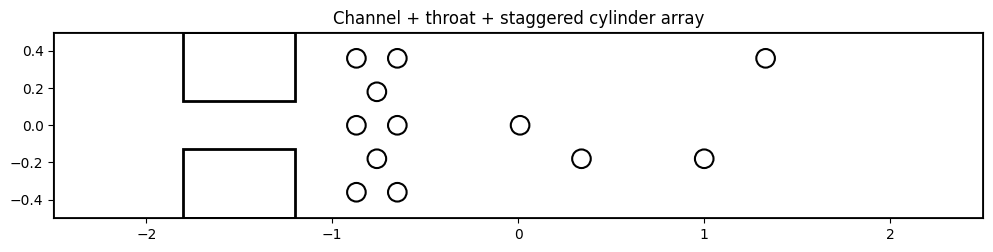

In [80]:
# @title Default title text
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(12, 3))

# outer channel
ax.add_patch(patches.Rectangle((-Lx/2, -Ly/2), Lx, Ly, fill=False, linewidth=2))

# obstacles
for kind, params, _ in obstacles:
    if kind == "disk":
        x, y, r = params
        ax.add_patch(patches.Circle((x, y), r, fill=False, linewidth=1.5))
    else:
        xmin, xmax, ymin, ymax = params
        ax.add_patch(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, linewidth=2))

ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-Lx/2, Lx/2)
ax.set_ylim(-Ly/2, Ly/2)
ax.set_title("Channel + throat + staggered cylinder array")
plt.show()


In [81]:
def boundary_wall(X, on_boundary):
    # Top and Bottom walls of the main channel
    on_wall = np.logical_and(
        np.logical_or(
            np.isclose(X[1], -D / 2, rtol=1e-05, atol=1e-08),
            np.isclose(X[1], D / 2, rtol=1e-05, atol=1e-08),
        ),
        on_boundary,
    )
    return on_wall

def boundary_inlet(X, on_boundary):
    # Left wall
    return np.logical_and(np.isclose(X[0], -L / 2, rtol=1e-5, atol=1e-8), on_boundary)

def boundary_outlet(X, on_boundary):
    # Right wall
    return np.logical_and(np.isclose(X[0], L / 2, rtol=1e-5, atol=1e-8), on_boundary)

def boundary_obstacles(X, on_boundary):
    # Detects the internal barrier walls
    # 1. Check if we are on the outer box (Inlet/Outlet/Top/Bottom main walls)
    on_left = np.isclose(X[0], -L/2)
    on_right = np.isclose(X[0], L/2)
    on_bottom = np.isclose(X[1], -D/2)
    on_top = np.isclose(X[1], D/2)

    on_outer_box = on_left | on_right | on_bottom | on_top

    # 2. If it is on a boundary, but NOT the outer box, it is the Barrier
    return np.logical_and(on_boundary, np.logical_not(on_outer_box))

# BC Objects
# No-slip for barrier walls
bc_obs_u = dde.DirichletBC(geom, lambda X: 0.0, boundary_obstacles, component=0)
bc_obs_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_obstacles, component=1)

# Outer walls
bc_wall_u = dde.DirichletBC(geom, lambda X: 0.0, boundary_wall, component=0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_wall, component=1)

# Inlet
bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component=0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_inlet, component=1)

# Outlet
bc_outlet_p = dde.DirichletBC(geom, lambda X: 0.0, boundary_outlet, component=2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_outlet, component=1)

In [82]:
# Define PDE system (Standard Navier-Stokes)
def pde(X, Y):
    # X = [x, y, t], Y = [u, v, p]
    du_t = dde.grad.jacobian(Y, X, i=0, j=2)
    dv_t = dde.grad.jacobian(Y, X, i=1, j=2)

    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)

    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    pde_u = du_t + Y[:, 0:1] * du_x + Y[:, 1:2] * du_y + 1 / rho * dp_x - (mu / rho) * (du_xx + du_yy)
    pde_v = dv_t + Y[:, 0:1] * dv_x + Y[:, 1:2] * dv_y + 1 / rho * dp_y - (mu / rho) * (dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]

ic_u = dde.IC(geom, lambda X: 0.0, lambda _, on_initial: on_initial, component=0)
ic_v = dde.IC(geom, lambda X: 0.0, lambda _, on_initial: on_initial, component=1)


In [85]:
data = dde.data.TimePDE(
    geom,
    pde,
    [
        # --- Spatial Boundaries ---
        bc_wall_u, bc_wall_v,      # Walls (No slip)
        bc_inlet_u, bc_inlet_v,    # Left Inlet (Flow enters here)
        bc_outlet_p, bc_outlet_v,  # Right Outlet (Flow exits here)
        bc_obs_u, bc_obs_v,        # Barrier walls (No slip)

        # --- Initial Conditions (t=0) ---
        ic_u, ic_v                 # State of fluid at start
    ],
    num_domain=1500,    # Points inside the channel
    num_boundary=600,  # Points on walls/inlet/outlet
    num_initial=600    # Points at time t=0
)

In [86]:
# Define neural network
net = dde.nn.FNN([3] + [64] * 5 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

In [93]:
# Compile and train
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=20000)

# Fine-tune with L-BFGS for better convergence
model.compile("L-BFGS")
losshistory, train_state = model.train(iterations=5000)

Compiling model...
'compile' took 0.006362 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
2         [3.77e-02, 3.02e-02, 7.54e-02, nan, nan, nan, nan, nan, nan, 1.62e-02, 1.88e-02, 9.16e-03, 1.83e-02]                                  [3.77e-02, 3.02e-02, 7.54e-02, nan, nan, nan, nan, nan, nan, 1.62e-02, 1.88e-02, 9.16e-03, 1.83e-02]                                  []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 8.386478 s

Compiling model...
'compile' took 0.002454 s

Training model...

Step      Train loss                                                                                                                            Test loss                                            

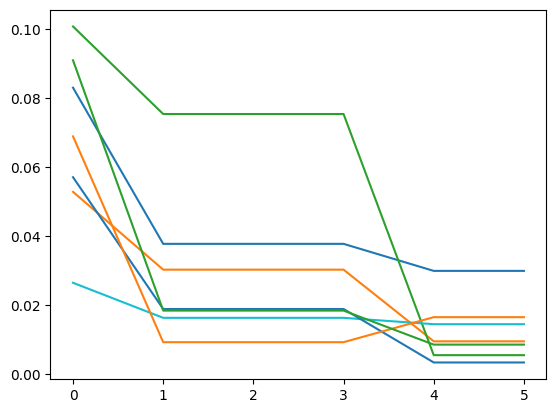

In [94]:

plt.plot(losshistory.loss_train)
plt.show()

Setting up Particle Simulation for Barrier Flow...


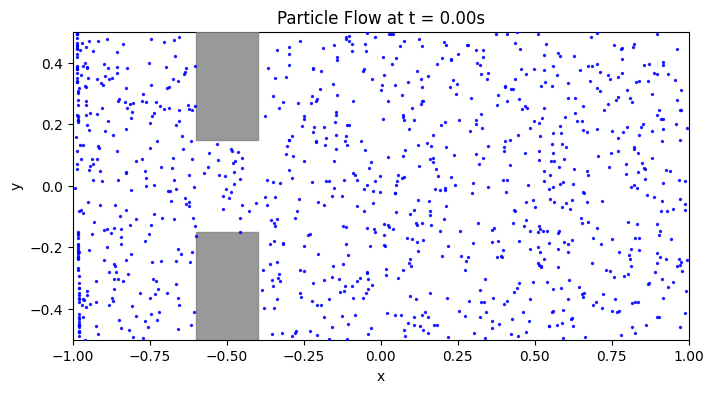

In [95]:
from matplotlib.animation import FuncAnimation

print("Setting up Particle Simulation for Barrier Flow...")

# --- 1. Define Barrier Collision Logic ---
def check_barrier_hit(x, y):
    """Check if particles hit the barrier obstacles."""
    # Barrier coordinates (must match geometry in Cell 1)
    b_x_start, b_x_end = -0.6, -0.4
    b_gap = gap_height / 2  # gap_height=0.3 from geometry

    # Check if inside top barrier
    in_top = (x >= b_x_start) & (x <= b_x_end) & (y >= b_gap) & (y <= D/2)
    # Check if inside bottom barrier
    in_bottom = (x >= b_x_start) & (x <= b_x_end) & (y <= -b_gap) & (y >= -D/2)

    return in_top | in_bottom

# --- 2. Initialize Particles ---
num_particles = 1000
p_x = np.random.uniform(-L / 2, L / 2, num_particles)
p_y = np.random.uniform(-D / 2, D / 2, num_particles)

# Clear initial bad spawns
bad = check_barrier_hit(p_x, p_y)
p_x[bad] = -L / 2

# --- 3. Setup Plot ---
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlim(-L / 2, L / 2)
ax.set_ylim(-D / 2, D / 2)
ax.set_aspect('equal')
ax.set_title("Particle Flow Through Barrier")
ax.set_xlabel("x")
ax.set_ylabel("y")

# Draw barrier obstacles
barrier_top_patch = plt.Rectangle(
    (barrier_x_start, gap_height/2),
    barrier_x_end - barrier_x_start,
    D/2 - gap_height/2,
    color='gray', alpha=0.8, zorder=5
)
barrier_bottom_patch = plt.Rectangle(
    (barrier_x_start, -D/2),
    barrier_x_end - barrier_x_start,
    D/2 - gap_height/2,
    color='gray', alpha=0.8, zorder=5
)
ax.add_patch(barrier_top_patch)
ax.add_patch(barrier_bottom_patch)

particles_plot = ax.scatter(p_x, p_y, s=2, c='blue', alpha=0.8, zorder=10)

# --- 4. Sub-stepping Update Loop ---
def update_particles(frame):
    global p_x, p_y

    total_dt_per_frame = 0.05
    steps = 5
    dt = total_dt_per_frame / steps
    current_t = frame * total_dt_per_frame

    for _ in range(steps):
        t_stack = np.full((num_particles, 1), current_t)
        X_in = np.column_stack([p_x, p_y, t_stack])

        vel = model.predict(X_in)
        u = vel[:, 0]
        v = vel[:, 1]

        p_x += u * dt
        p_y += v * dt

        # Check for collisions
        hit_barrier = check_barrier_hit(p_x, p_y)
        hit_out = p_x > L / 2
        hit_wall = (p_y > D / 2) | (p_y < -D / 2)

        mask_reset = hit_barrier | hit_out | hit_wall

        if np.any(mask_reset):
            n = np.sum(mask_reset)
            p_x[mask_reset] = -L / 2 + np.random.uniform(0, 0.05, n)
            p_y[mask_reset] = np.random.uniform(-D / 2, D / 2, n)

    particles_plot.set_offsets(np.c_[p_x, p_y])
    ax.set_title(f"Particle Flow at t = {current_t:.2f}s")
    return particles_plot,

ani = FuncAnimation(fig, update_particles, frames=200, interval=30, blit=True)
plt.show()

Generating animation for Barrier Flow...
Video saved successfully!


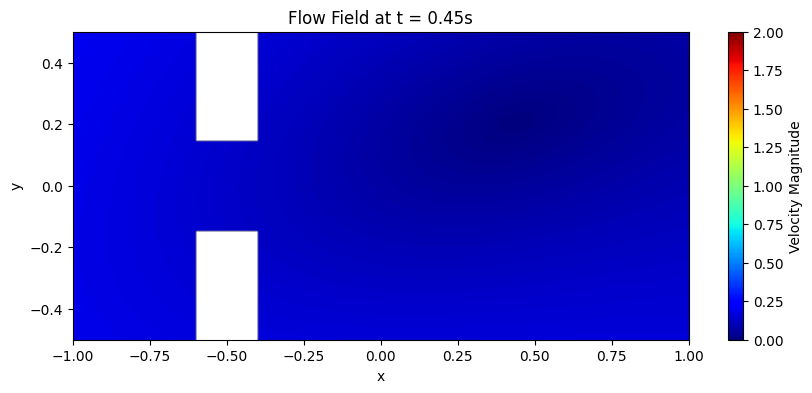

In [96]:
from matplotlib.animation import FFMpegWriter

print("Generating animation for Barrier Flow...")

# 1. Create the Regular Grid for Plotting
# We create a new grid here to ensure clean shapes
grid_x, grid_y = np.meshgrid(
    np.linspace(-L/2, L/2, 300),
    np.linspace(-D/2, D/2, 150)
)

def solid_mask(X, Y, obstacles):
    """Boolean mask: True inside solid obstacles."""
    mask = np.zeros_like(X, dtype=bool)
    for kind, params, _ in obstacles:
        if kind == "disk":
            x0, y0, r = params
            mask |= (X - x0)**2 + (Y - y0)**2 <= r**2
        elif kind == "rect":
            xmin, xmax, ymin, ymax = params
            mask |= (X >= xmin) & (X <= xmax) & (Y >= ymin) & (Y <= ymax)
    return mask


# 2. Define the Barrier Masks (MUST match the geometry in Cell 1)
# Barrier coordinates
b_x_start, b_x_end = -0.6, -0.4
b_gap = gap_height / 2  # Half of the gap height (gap_height=0.3 from geometry)

# Create boolean masks for the barriers
mask_top = (grid_x >= b_x_start) & (grid_x <= b_x_end) & (grid_y >= b_gap)
mask_bottom = (grid_x >= b_x_start) & (grid_x <= b_x_end) & (grid_y <= -b_gap)

# Combine them into one mask
mask_total = mask_top | mask_bottom

# 3. Setup the Figure
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("Transient Flow with Barrier (Vortex Generation)")

# Initialize the plot
cax = ax.imshow(np.zeros_like(grid_x),
                extent=(-L/2, L/2, -D/2, D/2),
                origin='lower',
                cmap='jet',
                vmin=0, vmax=2.0, # Adjusted scale for jet flow
                interpolation='bilinear')
fig.colorbar(cax, ax=ax, label='Velocity Magnitude')

# 4. The Animation Update Function
def update(frame):
    # Calculate current time (advancing 0.05s per frame)
    current_t = frame * 0.05

    # Create input coordinates for the whole grid
    t_column = np.full((grid_x.size, 1), current_t)
    X_predict = np.column_stack([grid_x.flatten(), grid_y.flatten(), t_column])

    # Predict velocity
    result = model.predict(X_predict)
    u = result[:, 0].reshape(grid_x.shape)
    v = result[:, 1].reshape(grid_x.shape)
    speed = np.sqrt(u**2 + v**2)

    # Apply the mask (Nan makes it white/transparent)
    speed[mask_total] = np.nan

    # Update the image
    cax.set_data(speed)
    ax.set_title(f"Flow Field at t = {current_t:.2f}s")
    return cax,

# 5. Run and Save
ani = FuncAnimation(fig, update, frames=10, interval=200, blit=False)

try:
    writer = FFMpegWriter(fps=20)
    ani.save("flow_field_barrier.mp4", writer=writer, dpi=200)
    print("Video saved successfully!")
except Exception as e:
    print(f"Could not save video (displaying instead): {e}")

plt.show()

In [97]:
# --- ADVANCED METRICS EVALUATION ---
print("Calculating Physics Metrics...")

# 1. Generate a grid of points to test the physics
# We check 5000 random points inside the domain
X_test = geom.random_points(5000)

# 2. Calculate Residuals (Physics Errors)
# We pass 'operator=pde' to tell the model:
# "Don't just give me velocity (u,v), give me the ERROR in the equations."
residuals = model.predict(X_test, operator=pde)

# The output 'residuals' is a list of arrays: [pde_u, pde_v, pde_cont]
# matching the order you returned in your def pde(...) function.
res_u = residuals[0]  # Momentum X error
res_v = residuals[1]  # Momentum Y error
res_cont = residuals[2]  # Continuity error (Mass conservation)

# 3. Compute Mean Errors
mean_res_u = np.mean(np.abs(res_u))
mean_res_v = np.mean(np.abs(res_v))
mean_res_cont = np.mean(np.abs(res_cont))

print("-" * 40)
print(f"Final Physics Metrics (Mean Absolute Error):")
print(f"1. Mass Conservation Error: {mean_res_cont:.6f}")
print(f"   (Ideal = 0.0. High = Liquid appearing/disappearing)")
print(f"2. X-Momentum Error:        {mean_res_u:.6f}")
print(f"3. Y-Momentum Error:        {mean_res_v:.6f}")
print("-" * 40)

# 4. Visualize Where the Physics Fails
# We plot the Mass Conservation Error.
# Bright spots = areas where the liquid is "breaking" physics (usually near walls).

fig, ax = plt.subplots(figsize=(10, 4))
# We use X_test[:, 0] (x-coords) and X_test[:, 1] (y-coords)
sc = ax.scatter(X_test[:, 0], X_test[:, 1], c=np.abs(res_cont), cmap='inferno', s=5, alpha=0.8)
plt.colorbar(sc, label='Mass Error magnitude')
ax.set_title("Physics Error Map (Continuity)")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
plt.show()

Calculating Physics Metrics...


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.patches as patches

# IMPORTANT: use the SAME geometry dimensions as your domain
# If your geometry uses Lx, Ly, use them here.
Nx, Ny = 500, 220
x = np.linspace(-Lx/2, Lx/2, Nx)
y = np.linspace(-Ly/2, Ly/2, Ny)
grid_x, grid_y = np.meshgrid(x, y)

# Solid mask (True inside solids)
mask = solid_mask(grid_x, grid_y, obstacles)

fig, ax = plt.subplots(figsize=(13, 3.5), dpi=150)

# Create the image first (so we can put obstacles above it via zorder)
w0 = np.zeros_like(grid_x)
w0_masked = np.ma.array(w0, mask=mask)

im = ax.imshow(
    w0_masked,
    extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
    origin="lower",
    interpolation="nearest",   # <<< KEY: avoids bleeding across solids
    animated=True,
    zorder=0
)

# Make masked/invalid values show as white/transparent-ish
cmap = im.get_cmap()
cmap.set_bad(color="white")
im.set_cmap(cmap)

# Draw obstacles ON TOP of the field
for kind, params, _ in obstacles:
    if kind == "disk":
        x0, y0, r = params
        ax.add_patch(patches.Circle(
            (x0, y0), r,
            facecolor="white", edgecolor="black",
            linewidth=1.6, zorder=5
        ))
    else:
        xmin, xmax, ymin, ymax = params
        ax.add_patch(patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            facecolor="white", edgecolor="black",
            linewidth=2.0, zorder=5
        ))

ax.set_xlim(-Lx/2, Lx/2)
ax.set_ylim(-Ly/2, Ly/2)
ax.set_aspect("equal", adjustable="box")
ax.set_title("PINN Navier–Stokes — Flow past obstacles")
ax.set_xlabel("x")
ax.set_ylabel("y")

cb = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
cb.set_label("Vorticity ω")

def get_uvp(t):
    pts = np.column_stack([grid_x.ravel(), grid_y.ravel(), np.full(grid_x.size, t)])
    pred = model.predict(pts)
    u = pred[:, 0].reshape(grid_x.shape)
    v = pred[:, 1].reshape(grid_x.shape)
    p = pred[:, 2].reshape(grid_x.shape)
    return u, v, p

def vorticity(u, v, x_vec, y_vec):
    # axis0 is y, axis1 is x
    dv_dy, dv_dx = np.gradient(v, y_vec, x_vec, edge_order=2)
    du_dy, du_dx = np.gradient(u, y_vec, x_vec, edge_order=2)
    return dv_dx - du_dy

times = np.linspace(0, 5, 160)

# Optional: fix color scale so it doesn't flicker
# You can set these after you see typical magnitudes:
vmin, vmax = -3.0, 3.0
im.set_clim(vmin, vmax)

def update(frame):
    t = times[frame]
    u, v, _ = get_uvp(t)
    w = vorticity(u, v, x, y)

    # mask solids properly (masked array is MUCH cleaner than NaNs here)
    w_masked = np.ma.array(w, mask=mask)
    im.set_data(w_masked)

    ax.set_title(f"PINN Navier–Stokes — t = {t:.2f}")
    return (im,)

ani = FuncAnimation(fig, update, frames=len(times), interval=40, blit=True)

writer = FFMpegWriter(fps=25, bitrate=2500)
ani.save("flow_obstacles_vorticity.mp4", writer=writer)
plt.close(fig)

print("Saved: flow_obstacles_vorticity.mp4")